In [ ]:
!pip install tensorflow==2.4.1 tensorflow-gpu==2.4.1 opencv-python matplotlib

In [10]:
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [11]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

In [12]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)
    

In [13]:
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [6]:
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'data\\positive'

In [14]:
POS_PATH

'data\\positive'

In [8]:
!tar -xf lfw.tgz

In [15]:
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'lfw'

In [16]:
import uuid

In [30]:
os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))

'data\\anchor\\3b651aac-f3ff-11ec-a03c-b803058baf19.jpg'

In [31]:
os.listdir('lfw')

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'lfw'

In [29]:
cap = cv2.VideoCapture(0)
while cap.isOpened(): 
    ret, frame = cap.read()
    frame = frame[120:120+250,200:200+250, :]
    if cv2.waitKey(1) & 0XFF == ord('a'):
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(imgname, frame)
    if cv2.waitKey(1) & 0XFF == ord('p'):
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(imgname, frame)
    cv2.imshow('Image Collection', frame)
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

In [ ]:
frame

In [ ]:
plt.imshow(frame)

In [32]:
frame[:250, :250, :].shape

(250, 250, 3)

In [33]:
def data_aug(img):
    data = []
    for i in range(9):
        img = tf.image.stateless_random_brightness(img, max_delta=0.02, seed=(1,2))
        img = tf.image.stateless_random_contrast(img, lower=0.6, upper=1, seed=(1,3))
        # img = tf.image.stateless_random_crop(img, size=(20,20,3), seed=(1,2))
        img = tf.image.stateless_random_flip_left_right(img, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_jpeg_quality(img, min_jpeg_quality=90, max_jpeg_quality=100, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_saturation(img, lower=0.9,upper=1, seed=(np.random.randint(100),np.random.randint(100)))
            
        data.append(img)
    
    return data

In [34]:
import os
import uuid

In [35]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(3000)
positive = tf.data.Dataset.list_files(POS_PATH+'\*.jpg').take(3000)
negative = tf.data.Dataset.list_files(NEG_PATH+'\*.jpg').take(3000)

In [36]:
dir_test = anchor.as_numpy_iterator()

In [37]:
print(dir_test.next())

b'data\\anchor\\23fe83ca-f3ff-11ec-82dd-b803058baf19.jpg'


In [38]:
def preprocess(file_path):
    byte_img = tf.io.read_file(file_path)
    img = tf.io.decode_jpeg(byte_img)
    img = tf.image.resize(img, (100,100))
    img = img / 255.0
    return img

In [39]:
img = preprocess('data\\anchor\\23fe83ca-f3ff-11ec-82dd-b803058baf19.jpg')

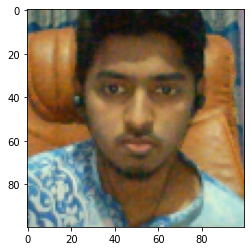

In [40]:
plt.imshow(img)

In [41]:
img.numpy().min() 

0.0

In [42]:
img.numpy().max() 

0.95392156

In [43]:
dataset.map(preprocess)

NameError: name 'dataset' is not defined

In [44]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [45]:
data

<ConcatenateDataset shapes: ((), (), ()), types: (tf.string, tf.string, tf.float32)>

In [46]:
samples = data.as_numpy_iterator()

In [49]:
example = samples.next()

In [50]:
example

(b'data\\anchor\\28abd1e2-f3ff-11ec-bd2e-b803058baf19.jpg',
 b'data\\positive\\03258e68-f3fe-11ec-a877-b803058baf19.jpg',
 1.0)

In [51]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [52]:
res = preprocess_twin(*exampple)

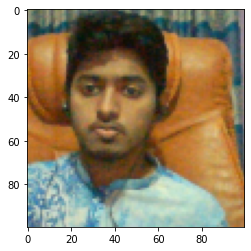

In [53]:
plt.imshow(res[1])

In [54]:
res[2]

1.0

In [55]:
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=10000)

In [56]:
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [57]:
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

In [58]:
inp = Input(shape=(100,100,3), name='input_image')

In [59]:
c1 = Conv2D(64, (10,10), activation='relu')(inp)

In [60]:
m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

In [61]:
c2 = Conv2D(128, (7,7), activation='relu')(m1)
m2 = MaxPooling2D(64, (2,2), padding='same')(c2)

In [62]:
c3 = Conv2D(128, (4,4), activation='relu')(m2)
m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

In [63]:
c4 = Conv2D(256, (4,4), activation='relu')(m3)
f1 = Flatten()(c4)
d1 = Dense(4096, activation='sigmoid')(f1)

In [64]:
mod = Model(inputs=[inp], outputs=[d1], name='embedding')

In [65]:
mod.summary()

Model: "embedding"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_image (InputLayer)     [(None, 100, 100, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 91, 91, 64)        19264     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 46, 46, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 40, 40, 128)       401536    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 20, 20, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 17, 17, 128)       262272    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 9, 9, 128)         0 